In [18]:
import pandas as pd
import numpy as np
import requests
import json
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Introduction

This notebook will describe the analytic steps taken to build the data driven insights that power the app idea detailed in this [blog](https://insightsquotient.co.uk/2020/09/29/covid-19-incidence-app-risk-alerts-by-postcode/).


## Data Loading and Processing

In [19]:
## Load the cases data using our API
r = requests.get('https://iqapi.azurewebsites.net/api/UkmsoaCases').json()
cases_data = pd.DataFrame(r['results'])
## 0 is -99 for some reason
cases_data = cases_data.replace(-99, 0)
cases_data.head()

,rgn19_cd,rgn19_nm,utla19_cd,utla19_nm,lad19_cd,lad19_nm,msoa11_cd,msoa11_hclnm,wk_05,wk_06,...,wk_31,wk_32,wk_33,wk_34,wk_35,wk_36,wk_37,wk_38,wk_39,last_7_days
0,E12000007,London,E09000001,City of London,E09000001,City of London,E02000001,City of London,0,0,...,0,0,0,3.0,0.0,0.0,0,0,None,None
1,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000002,Marks Gate,0,0,...,0,0,0,0.0,0.0,0.0,0,5,None,None
2,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000004,Eastbrookend,0,0,...,0,0,0,0.0,0.0,0.0,0,4,None,None
3,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000007,Central Park & Frizlands Lane,0,0,...,0,0,0,0.0,0.0,4.0,6,3,None,None
4,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000005,Becontree Heath,0,0,...,0,0,0,0.0,0.0,5.0,3,3,None,None


In [3]:
## Load UK population data at MSOA level via the NOMIS API
## The url is long due to the number of parameters selected
pop_data = pd.read_csv('http://www.nomisweb.co.uk/api/v01/dataset/NM_2010_1.data.csv?geography=1245710776...1245710790,1245712478...1245712543,1245710706...1245710716,1245715055,1245710717...1245710734,1245714957,1245713863...1245713902,1245710735...1245710751,1245714958,1245715056,1245710752...1245710775,1245709926...1245709950,1245714987,1245714988,1245709951...1245709978,1245715039,1245709979...1245710067,1245710832...1245710868,1245712005...1245712034,1245712047...1245712067,1245711988...1245712004,1245712035...1245712046,1245712068...1245712085,1245710791...1245710831,1245712159...1245712222,1245709240...1245709350,1245715048,1245715058...1245715063,1245709351...1245709382,1245715006,1245709383...1245709577,1245713352...1245713362,1245715027,1245713363...1245713411,1245715017,1245713412...1245713456,1245715030,1245713457...1245713502,1245709578...1245709655,1245715077...1245715079,1245709679...1245709716,1245709656...1245709678,1245709717...1245709758,1245710900...1245710939,1245714960,1245715037,1245715038,1245710869...1245710899,1245714959,1245710940...1245711009,1245713903...1245713953,1245715016,1245713954...1245713977,1245709759...1245709925,1245714949,1245714989,1245714990,1245715014,1245715015,1245710411...1245710660,1245714998,1245715007,1245715021,1245715022,1245710661...1245710705,1245711010...1245711072,1245714961,1245714963,1245714965,1245714996,1245714997,1245711078...1245711112,1245714980,1245715050,1245715051,1245711073...1245711077,1245712223...1245712237,1245714973,1245712238...1245712284,1245714974,1245712285...1245712294,1245715018,1245712295...1245712306,1245714950,1245712307...1245712316,1245715065,1245715066,1245713503...1245713513,1245714966,1245713514...1245713544,1245714962,1245713545...1245713581,1245714964,1245715057,1245713582...1245713587,1245715010,1245715011,1245713588...1245713627,1245715012,1245715013,1245713628...1245713665,1245713774...1245713779,1245715008,1245715009,1245713780...1245713862,1245713978...1245714006,1245715049,1245714007...1245714019,1245715052,1245714020...1245714033,1245714981,1245714034...1245714074,1245711113...1245711135,1245714160...1245714198,1245711159...1245711192,1245711136...1245711158,1245714270...1245714378,1245714616...1245714638,1245714952,1245714639...1245714680,1245710068...1245710190,1245714953,1245714955,1245715041...1245715047,1245710191...1245710231,1245714951,1245710232...1245710311,1245714956,1245710312...1245710339,1245714954,1245710340...1245710410,1245715040,1245714843...1245714927,1245711814...1245711833,1245711797...1245711813,1245711834...1245711849,1245711458...1245711478,1245711438...1245711457,1245715023,1245715024,1245711479...1245711512,1245715005,1245715071,1245711915...1245711936,1245714971,1245711937...1245711987,1245715019,1245715020,1245712611...1245712711,1245715068,1245712712...1245712784,1245713023...1245713175,1245713666...1245713758,1245715053,1245715054,1245713759...1245713773,1245714379...1245714395,1245714972,1245714396...1245714467,1245708449...1245708476,1245708289,1245708620...1245708645,1245715064,1245715067,1245708646...1245708705,1245714941,1245708822...1245708865,1245708886...1245708919,1245714947,1245708920...1245708952,1245714930,1245714931,1245714944,1245708978...1245709014,1245709066...1245709097,1245714948,1245709121...1245709150,1245714999,1245715000,1245709179...1245709239,1245708290...1245708310,1245714945,1245708311...1245708378,1245714932,1245708379...1245708448,1245714929,1245714934,1245714936,1245708477...1245708519,1245714935,1245708520...1245708557,1245714938,1245708558...1245708592,1245714940,1245708593...1245708619,1245714933,1245715072...1245715076,1245708706...1245708733,1245714942,1245715028,1245708734...1245708794,1245714943,1245708795...1245708821,1245714939,1245708866...1245708885,1245708953...1245708977,1245709015...1245709042,1245714946,1245715069,1245715070,1245709043...1245709065,1245709098...1245709120,1245714982,1245709151...1245709178,1245711551...1245711565,1245711690...1245711722,1245711779...1245711796,1245711513...1245711550,1245711658...1245711689,1245711723...1245711746,1245714967,1245711588...1245711619,1245711747...1245711778,1245711566...1245711587,1245711620...1245711657,1245711850...1245711884,1245714969,1245711885...1245711914,1245714970,1245712544...1245712554,1245715003,1245715004,1245712555...1245712610,1245712860...1245712894,1245714975,1245714984,1245712895...1245712958,1245714968,1245714976,1245714977,1245712959...1245713022,1245713176...1245713206,1245715001,1245715002,1245713207...1245713279,1245714978,1245713280...1245713291,1245715025,1245715026,1245713292...1245713337,1245714979,1245713338...1245713351,1245714075...1245714144,1245715032,1245714145...1245714159,1245714468...1245714493,1245714983,1245714494...1245714587,1245714937,1245714588...1245714603,1245714985,1245714604...1245714615,1245714681...1245714780,1245711193...1245711219,1245711375...1245711395,1245715029,1245715031,1245711220...1245711270,1245715033...1245715036,1245712086...1245712158,1245714928,1245711271...1245711294,1245714991,1245714992,1245711327...1245711358,1245711396...1245711413,1245711295...1245711326,1245711414...1245711437,1245714993...1245714995,1245711359...1245711374,1245714986,1245714781...1245714842,1245712317...1245712477,1245712785...1245712859,1245714199...1245714269,1245715080...1245715134,1245715485,1245715135...1245715171,1245715486,1245715172...1245715188,1245715480,1245715482,1245715189...1245715196,1245715487,1245715197...1245715236,1245715484,1245715237...1245715285,1245715483,1245715286...1245715319,1245715434...1245715479,1245715488,1245715489,1245715320...1245715356,1245715481,1245715357...1245715433&date=latest&gender=0&c_age=200&measures=20100&select=date_name,geography_name,geography_code,gender_name,c_age_name,measures_name,obs_value,obs_status_name')
## Keeping only the msoa code and the population
pop_data = pop_data[['GEOGRAPHY_CODE', 'OBS_VALUE']]
pop_data.head()

,GEOGRAPHY_CODE,OBS_VALUE
0,E02002559,9157
1,E02002560,6087
2,E02002561,5305
3,E02002562,5840
4,E02002563,5446


In [4]:
## Select the column we wish to investigate in thes cases data, each column is 1 week, each row is 1 MSOA
latest_col = cases_data.columns[-3]
cases_data['latest_cases'] = cases_data[latest_col]
cases_data['latest_cases'].head()

0    3.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: latest_cases, dtype: float64

In [5]:
## merging the cases data with the population data
merged_data = pd.merge(cases_data, pop_data, left_on='msoa11_cd', right_on='GEOGRAPHY_CODE')
merged_data.head()

,rgn19_cd,rgn19_nm,utla19_cd,utla19_nm,lad19_cd,lad19_nm,msoa11_cd,msoa11_hclnm,wk_05,wk_06,...,wk_31,wk_32,wk_33,last_7_days,wk_34,wk_35,wk_36,latest_cases,GEOGRAPHY_CODE,OBS_VALUE
0,E12000007,London,E09000001,City of London,E09000001,City of London,E02000001,City of London,0,0,...,0,0,0,None,3.0,0.0,0.0,3.0,E02000001,9721
1,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000004,Eastbrookend,0,0,...,0,0,0,None,0.0,0.0,0.0,0.0,E02000004,6687
2,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000002,Marks Gate,0,0,...,0,0,0,None,0.0,0.0,0.0,0.0,E02000002,7735
3,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000005,Becontree Heath,0,0,...,0,0,0,None,0.0,0.0,5.0,0.0,E02000005,10432
4,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000007,Central Park & Frizlands Lane,0,0,...,0,0,0,None,0.0,0.0,4.0,0.0,E02000007,10048


In [6]:
## calculating the rate per 10k
merged_data['rate_per_10k'] = merged_data[latest_col] / merged_data['OBS_VALUE'] * 10000

In [7]:
## calculating an indicator that we can use to determine the 'performance' of each MSOA
mean_rate = merged_data['rate_per_10k'].mean()
merged_data['expected_value'] = mean_rate * merged_data['OBS_VALUE'] / 10000
merged_data['indicator'] = merged_data['rate_per_10k'] / merged_data['expected_value']
merged_data['scaled_indicator'] = merged_data['indicator']/merged_data['indicator'].max()

In [8]:
merged_data.head()

,rgn19_cd,rgn19_nm,utla19_cd,utla19_nm,lad19_cd,lad19_nm,msoa11_cd,msoa11_hclnm,wk_05,wk_06,...,wk_34,wk_35,wk_36,latest_cases,GEOGRAPHY_CODE,OBS_VALUE,rate_per_10k,expected_value,indicator,scaled_indicator
0,E12000007,London,E09000001,City of London,E09000001,City of London,E02000001,City of London,0,0,...,3.0,0.0,0.0,3.0,E02000001,9721,3.086102,0.576047,5.357377,0.041049
1,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000004,Eastbrookend,0,0,...,0.0,0.0,0.0,0.0,E02000004,6687,0.000000,0.396258,0.000000,0.000000
2,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000002,Marks Gate,0,0,...,0.0,0.0,0.0,0.0,E02000002,7735,0.000000,0.458361,0.000000,0.000000
3,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000005,Becontree Heath,0,0,...,0.0,0.0,5.0,0.0,E02000005,10432,0.000000,0.618180,0.000000,0.000000
4,E12000007,London,E09000002,Barking and Dagenham,E09000002,Barking and Dagenham,E02000007,Central Park & Frizlands Lane,0,0,...,0.0,0.0,4.0,0.0,E02000007,10048,0.000000,0.595425,0.000000,0.000000


In [9]:
## loading the shape file for our data, this could take some time to download and load into the notebook
path = 'https://opendata.arcgis.com/datasets/826dc85fb600440889480f4d9dbb1a24_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D'
geodata = gpd.read_file(path)

In [10]:
## merging our new shape data with out existing cases/population data
geo_df = geodata.merge(merged_data, left_on='msoa11cd', right_on='msoa11_cd')

In [11]:
geo_df.head()

,objectid,msoa11cd,msoa11nm,msoa11nmw,st_areasha,st_lengths,geometry,rgn19_cd,rgn19_nm,utla19_cd,...,wk_34,wk_35,wk_36,latest_cases,GEOGRAPHY_CODE,OBS_VALUE,rate_per_10k,expected_value,indicator,scaled_indicator
0,1,E02000001,City of London 001,City of London 001,2.897837e+06,9297.741827,"POLYGON ((532153.703 182165.155, 532158.249 18...",E12000007,London,E09000001,...,3.0,0.0,0.0,3.0,E02000001,9721,3.086102,0.576047,5.357377,0.041049
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2.161565e+06,8307.071886,"POLYGON ((548877.684 191097.284, 548877.386 19...",E12000007,London,E09000002,...,0.0,0.0,0.0,0.0,E02000002,7735,0.000000,0.458361,0.000000,0.000000
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,2.141516e+06,9359.991638,"POLYGON ((548958.555 189072.177, 548954.517 18...",E12000007,London,E09000002,...,0.0,0.0,4.0,0.0,E02000003,11174,0.000000,0.662149,0.000000,0.000000
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,2.492948e+06,8476.616902,"POLYGON ((551549.998 187364.637, 551528.633 18...",E12000007,London,E09000002,...,0.0,0.0,0.0,0.0,E02000004,6687,0.000000,0.396258,0.000000,0.000000
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,1.187953e+06,7322.466319,"POLYGON ((549237.051 187627.942, 549241.319 18...",E12000007,London,E09000002,...,0.0,0.0,5.0,0.0,E02000005,10432,0.000000,0.618180,0.000000,0.000000


## Plotting

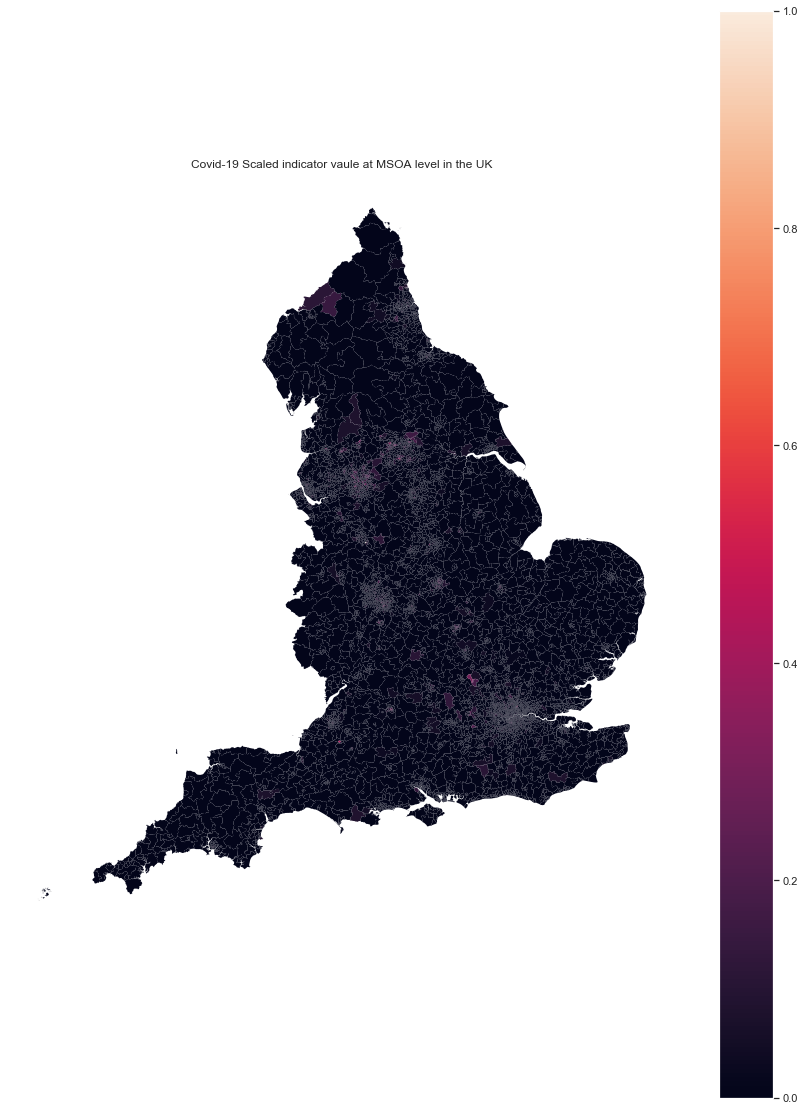

In [12]:
## Plotting a choropleth chart using our indicator field, for more information on choropleths check out the 
## Furlough notebook
fig, ax = plt.subplots(figsize=(15,20))
geo_df.plot(ax=ax, column='scaled_indicator', linewidth=0, legend=True)
plt.title('Covid-19 Scaled indicator vaule at MSOA level in the UK')
plt.axis('off')
plt.grid(b=None)

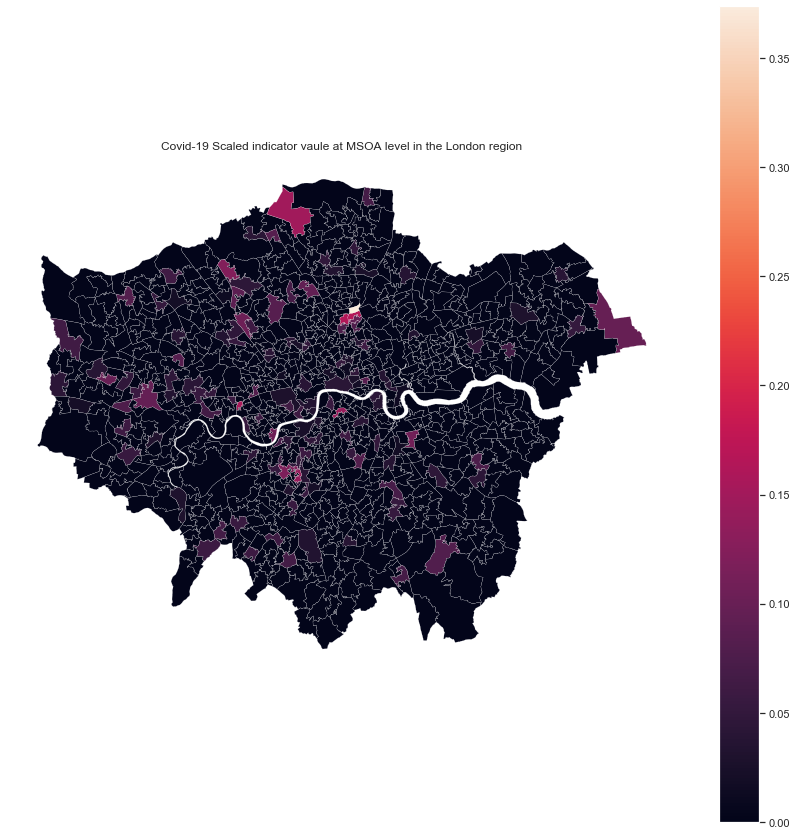

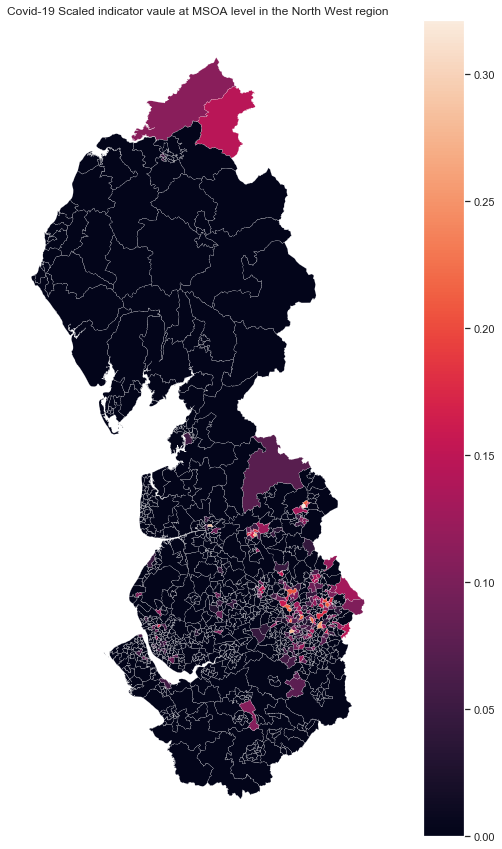

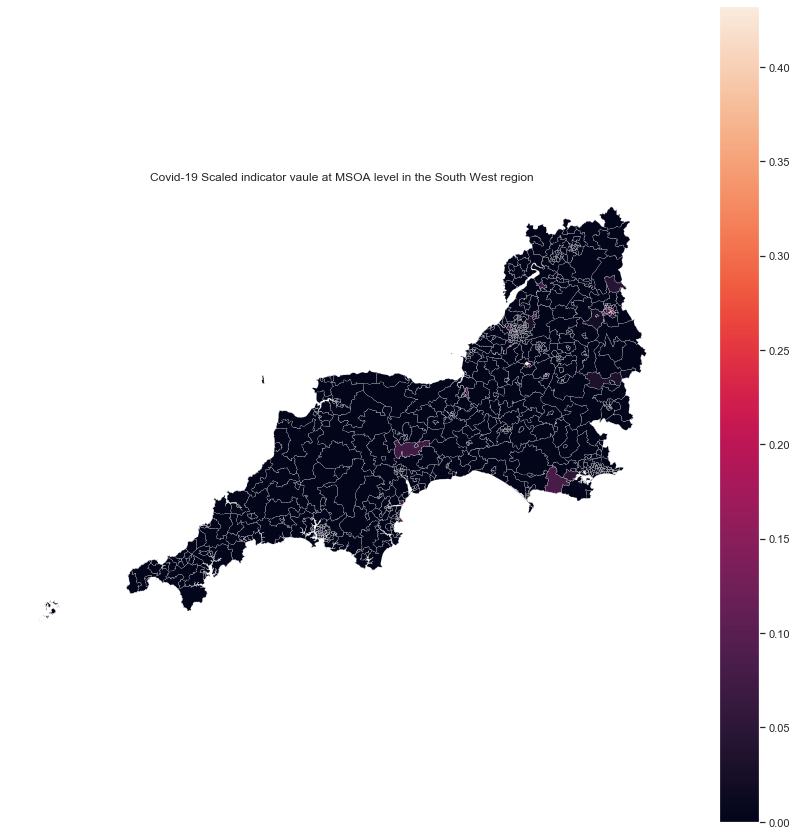

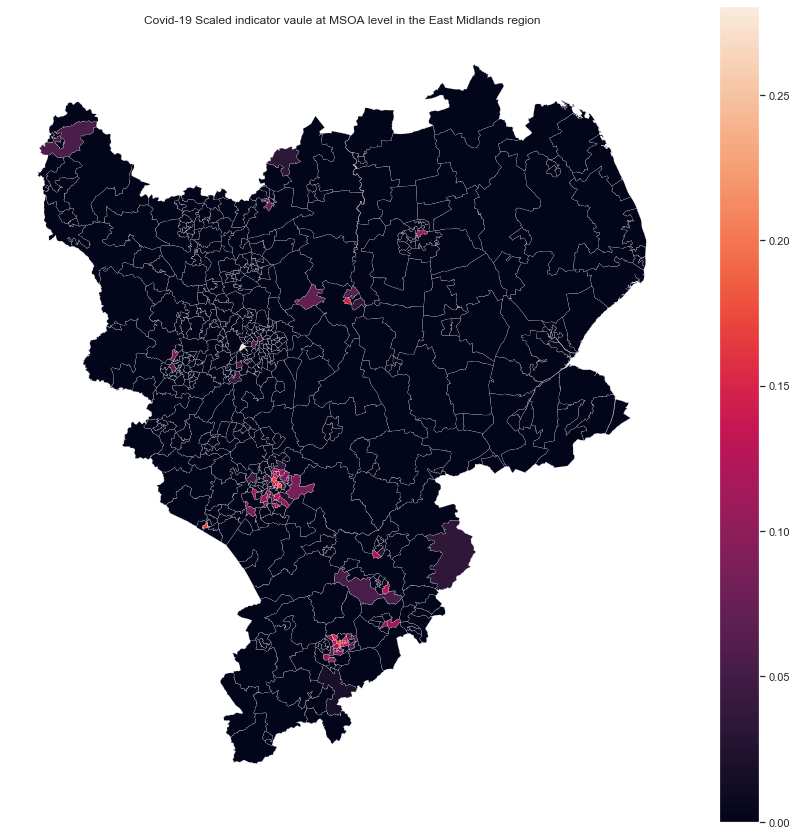

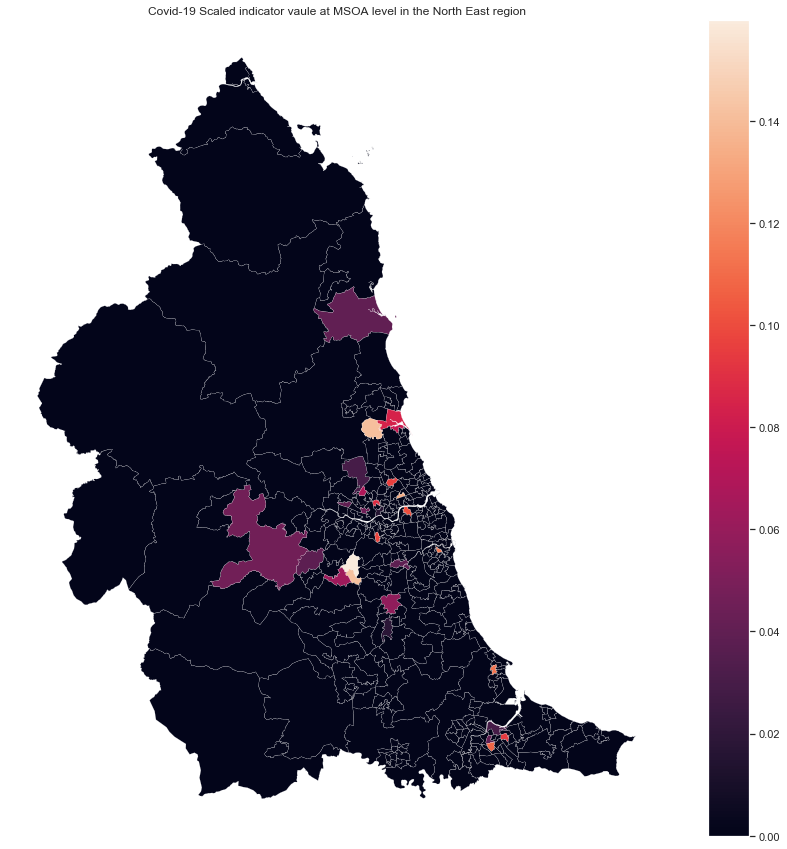

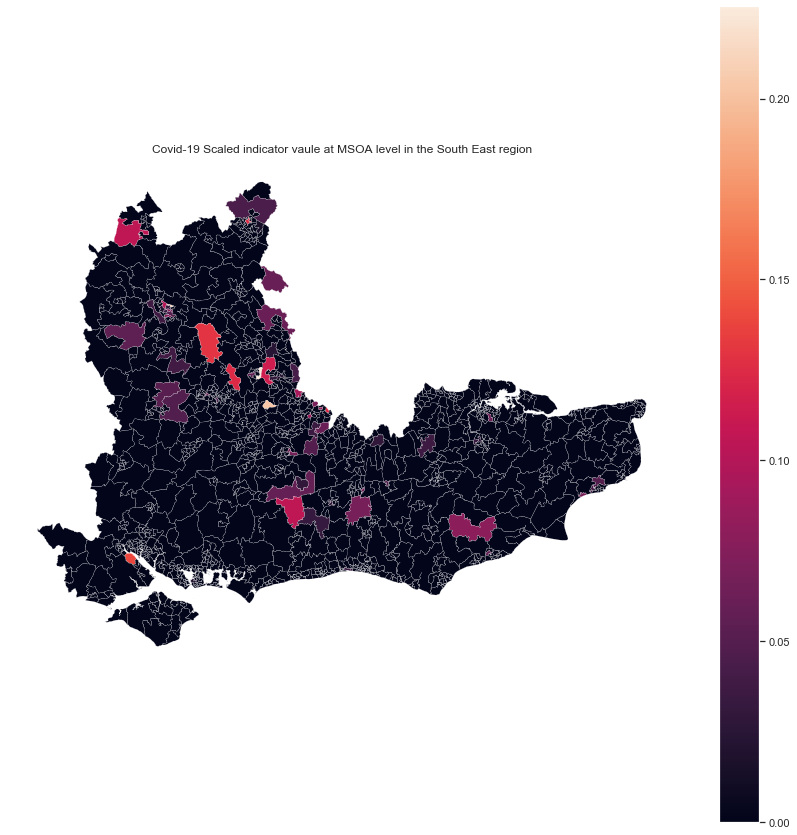

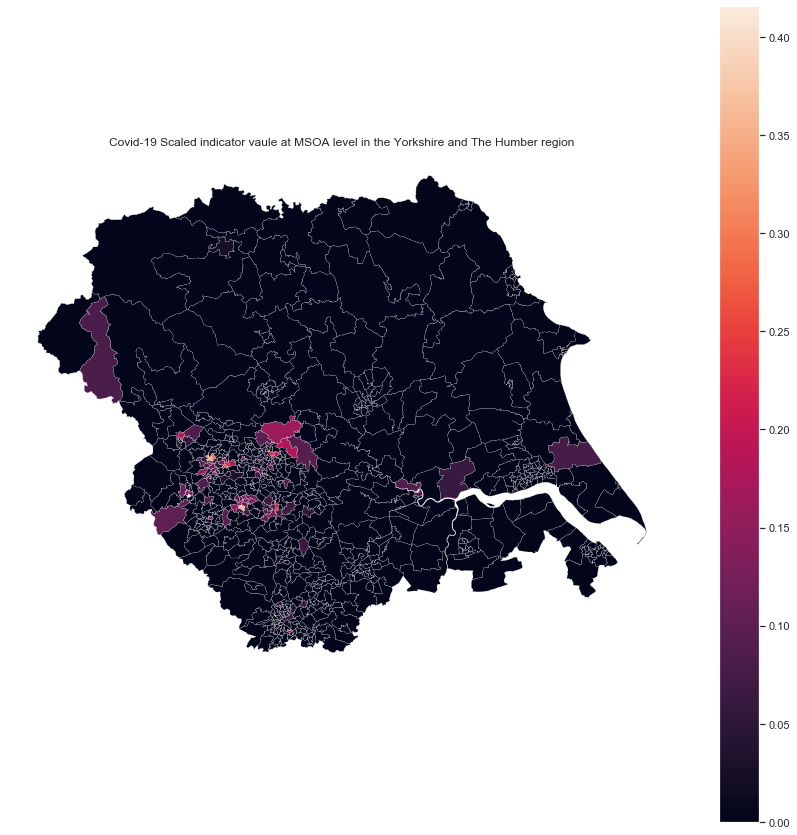

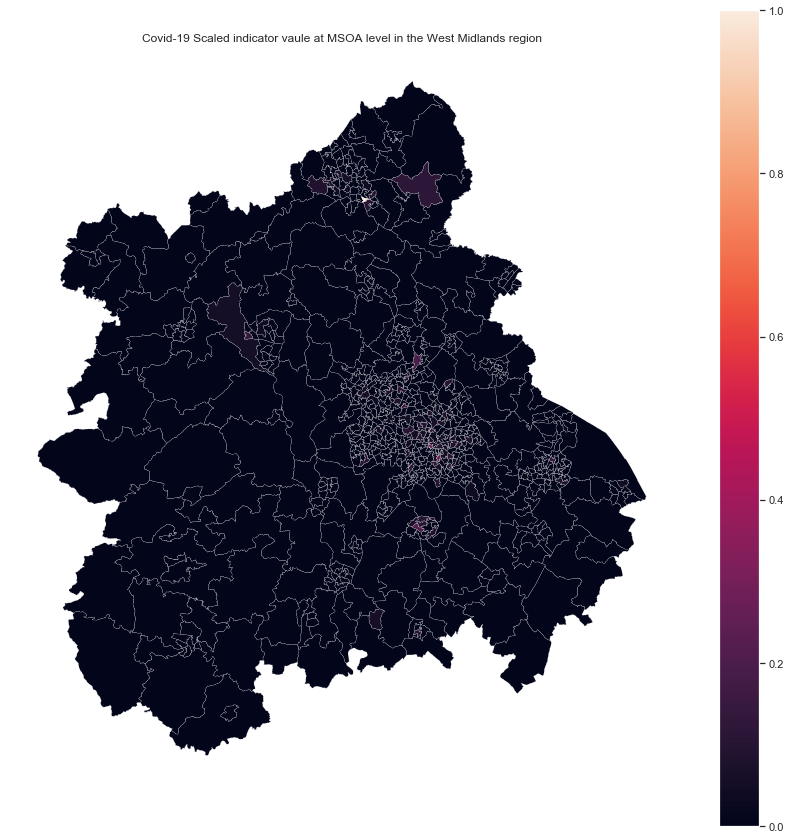

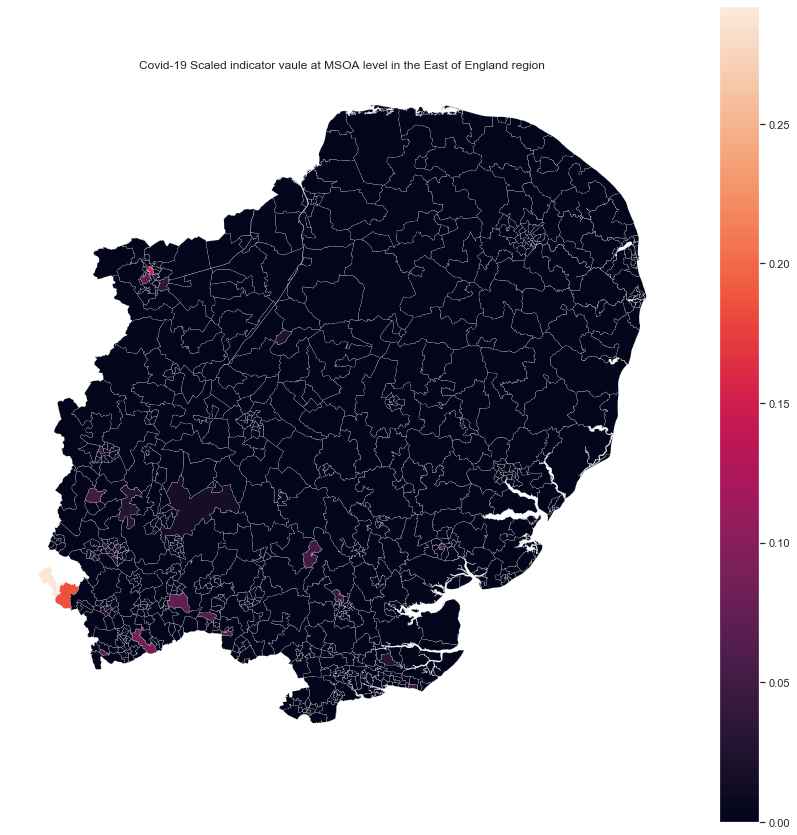

In [13]:
## plotting each region individually for more clarity in densely populated regions
for rgn in geo_df['rgn19_nm'].unique():
    fig, ax = plt.subplots(figsize=(15,15))
    geo_df[geo_df['rgn19_nm']==rgn].plot(ax=ax, column='scaled_indicator', linewidth=0.15, legend=True)
    plt.title('Covid-19 Scaled indicator vaule at MSOA level in the %s region' % (rgn))
    plt.axis('off')
    plt.grid(b=None)